# Lab 4 - Applying the Parametric Bootstrap for Sea-Level Rise
**Due**: Monday, 3/06 by 1:00pm.

Make sure you include your name and ID below for submission. <br>
**Name**:  <br>
**ID**:

## Contents

In [1]:
# load project environment
import Pkg # load the Pkg package manager
Pkg.activate(@__DIR__) # activate the environment in the directory of the script file
Pkg.instantiate() # make sure all of the needed packages are installed with correct versions

  Activating project at `~/Teaching/BEE6940/labs/lab05`


---

## Introduction

In class, we discussed how the parametric bootstrap could be used for uncertainty quantification. In this lab, we'll use the [Rahmstorf (2007)](https://doi.org/10.1073/pnas.0907765106) semi-empirical sea-level model,
$$H(t+1) = H(t) + \alpha (T(t) - T_0),$$
where where $T_0$ is the temperature (in $^\circ C$) where sea-level is in equilibrium ($dH/dt = 0$), and $\alpha$ is the sea-level rise sensitivity to temperature. $T_0$ and $\alpha$ are the parameters that we will treat as uncertain for this analysis.

## Setup

### Loading Packages

We will use the following packages in this notebook.

In [2]:
using Random # random number generation tools
using DataFrames # dataframe structures
using CSVFiles # interface for working with CSV files
using Plots # plotting tools
using StatsBase # basic stats functions
using Optim # optimization tools
using Distributions # API for interacting with probability distributions
using StatsPlots # additional statistical plotting functions

[ Info: Precompiling Optim [429524aa-4258-5aef-a3af-852621145aeb]


### Loading Data

Let's first load the sea-level and temperature data from the `data/` directory:
- Global mean sea level: `data/CSIRO_Recons_gmsl_yr_2015.csv`
- Temperature: `data/HadCRUT.5.0.1.0.analysis.summary_series.global.annual.csv`

In [7]:
# load data files
slr_data = DataFrame(load("data/CSIRO_Recons_gmsl_yr_2015.csv"))
gmt_data = DataFrame(load("data/HadCRUT.5.0.1.0.analysis.summary_series.global.annual.csv"))
slr_data[:, :Time] = slr_data[:, :Time] .- 0.5; # remove 0.5 from Times
dat = leftjoin(slr_data, gmt_data, on="Time") # join data frames on time
select!(dat, [1, 2, 4])  # drop columns we don't need
first(dat, 6)

Row,Time,GMSL (mm),Anomaly (deg C)
,Float64,Float64,Float64?
1,1880.0,-158.7,-0.315832
2,1881.0,-153.1,-0.232246
3,1882.0,-169.9,-0.29553
4,1883.0,-164.6,-0.346474
5,1884.0,-143.7,-0.49232
6,1885.0,-145.2,-0.471124


### Set Up The SLR Model

Now, let's define a function for the Rahmstorf model. We need to add one more parameter, $H_0$, to represent the initial sea-level at the start of the time period.

In [36]:
function rahmstorf_model(α, T₀, H₀, temp_data)
    temp_effect = α .* (temp_data .- T₀)
    slr_predict = cumsum(temp_effect) .+ H₀
    return slr_predict
end

rahmstorf_model (generic function with 1 method)

### Fit the Model and Calculate Residuals

Now, let's fit this model to get the SLR trend. We will do this by minimizing the least-square error.

In [48]:
rmse(y, ŷ) = sqrt(mean((y .- ŷ).^2))
# optimize using a parameter p, with p[1] = α and p[2] = T₀

years = dat[:, 1]
sealevels = dat[:, 2]
temp = dat[:, 3]

function minimize_mse(p, temp, sealevels)
    predict = rahmstorf_model(p[1], p[2], p[3], temp)
    return rmse(predict, sealevels)
end
optim_out = Optim.optimize(p -> minimize_mse(p, temp, sealevels), [1.0, 0.0, 0.0])
params = Optim.minimizer(optim_out)
@show params;

params = [1.8636596824562823, -0.9711430993147957, -157.33666238607228]


Plotting the fit:

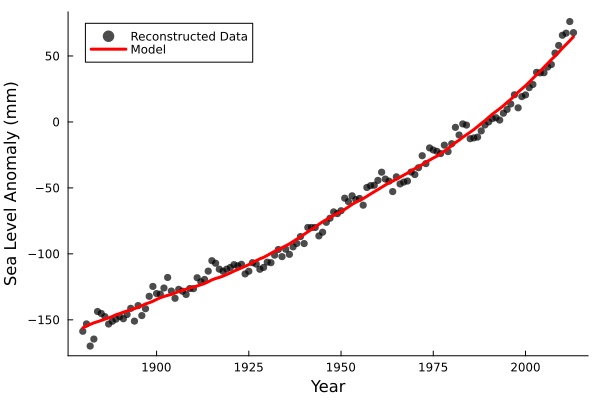

In [50]:
slr_hindcast = rahmstorf_model(params[1], params[2], params[3], temp)
scatter(years, sealevels, color=:black, alpha=0.7, label="Reconstructed Data", legend=:topleft, grid=false, xaxis="Year", yaxis="Sea Level Anomaly (mm)")
plot!(years, slr_hindcast, color=:red, linewidth=3, label="Model")

Finally, let's calculate the residuals, which we will use in the bootstrap analysis.

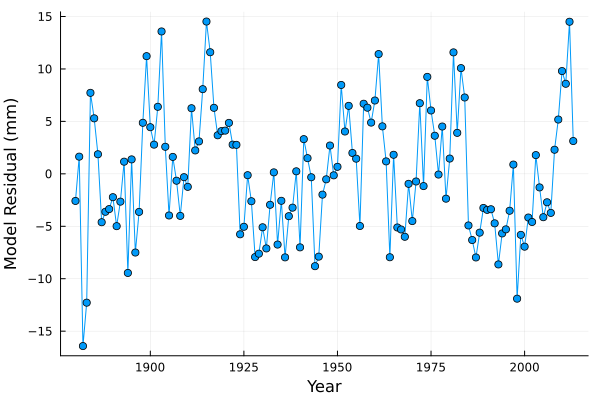

In [57]:
residuals = sealevels .- slr_hindcast
plot(years, residuals, marker=:circle, legend=:false, xlabel="Year", ylabel="Model Residual (mm)")

## Exercises
Complete the following exercises. Convert your completed notebook to a PDF and submit it to the Gradescope Assignment "Lab 4".

Remember to evaluate all of your code cells, in order (using a Run All command). This will make sure all output is visible and that the code cells were evaluated in the correct order.

### Exercise 1: Resampling Residuals

Begin by non-parametrically bootstrapping the residuals.

#### Exercise 1.1 (5 points)

Generate 1,000 bootstrapped sea-level series by re-sampling the residuals and adding them to the modeled sea-level trend. Plot the central 95% interval (the 2.5% and 97.5% quantiles for each year) of these bootstrap realizations.

#### Exercise 1.2 (5 points)

Refit your model to each of your bootstrap realizations.

#### Exercise 1.3 (5 points)

Plot the histograms for each of the uncertain parameters, $\alpha$, $T_0$, and $H_0$. Also plot a correlation or corner plot using `corrplot()` or `cornerplot()` from `StatsPlots.jl`. You will need to convert your parameter fits to a `Matrix` or a `DataFrame` if they are not already in that form (with a `DataFrame` if you want the variables named in the plot, which is not necessary).


### Exercise 2: Modeling Residuals with an Autoregressive Process

In Exercise 1, we treated the residuals as independent realizations, and since we had a large number of them, we used the non-parametric bootstrap on them. In this exercise, we will model them using an AR(1) (autoregressive with lag-1) time-series model. The following code implements the likelihood function for an AR(1) process with lag $\rho$ and error variance $\sigma^2$,
$$
\begin{gather*}
y_t = \rho y_{t+1} + \varepsilon_t, \\
 \varepsilon \sim \text{Normal}(0, \sigma^2).
\end{gather*}
$$

In [ ]:
function ar1_likelihood(y, ρ, σ²)

    n = length(y)
    σ²_proc = σ²/(1-ρ) # stationary process variance for each term
    error_dist = Normal(0, σ²_proc)
    # initialize log-likelihood with first term in the series
    log_likelihood = logpdf(error_dist, y[1])
    # compute errors and add log-likelihoods
    ε = y[2:n] .- (ρ * y[1:(n-1)])
    log_likelihood += sum((x -> logpdf(error_dist, x)).(ε))
    return log_likelihood
end

#### Exercise 2.1 (10 points)

Write a wrapper function (intended for use with `gsa`) which returns the optimal levee height given the varying input parameters.

#### Exercise 2.2 (10 points)

Use the Method of Morris, with the same parameter ranges as in Exercise 1 and the additional parameters below, to compute the sensitivities of the optimal height to variability in the parameter values.

| Parameter | Lower Bound | Upper Bound |
|:---------:|------------:|------------:|
| $I_0$ | $0$ | $1 \times 10^7$ |
| $k$ | $3.8 \times 10^7$ | $4.5 \times 10^7$ |

#### Exercise 2.3 (10 points)

Plot the means and variances of the sensitivity indices. What is different from the results in Exercise 1.2? Does this make sense?

## References

Give credit to any consulted references here, whether they were your classmates, online resources, or anything else.